# Прогнозирование временного ряда выработки электроэнергии

Имеются два временных ряда: первый — это среднесуточная выработка электроэнергии ветряной установкой. 
Другой — среднесуточная выработка электроэнергии при помощи дизельного генератора. Оба показателя измеряются в кВт⋅ч.

Помимо данных двух временных рядов имеются временные ряды дополнительных параметров, таких как скорость ветра, температура воздуха и т.д.

Расшифровка представлена ниже (целевая переменная выделена жирным начертанием):

* datetime - День

* **diesel_fuel_kWh - Выработка эл.энергии ДЭС,  кВтч** 

* wind_power_kWh - Выработка эл.энергии ВЭУ,  кВтч

* diesel_time_h - Время работы дизельной электростанции (ДЭС),  ч

* wind_time_h - Время работы ветряной электроустановки (ВЭУ),  ч 

* velocity_max_msec - Скорость ветра (мах), м/с
 
* velocity_mean_msec - Скорость ветра (ср), м/с

* tmp_grad - Температура окр. среды (ср), град


Задача: построить модель, которая позволяет предсказывать значения временного ряда diesel_fuel_kWh на заданное количество суток вперёд. Таким образом, решается задача предсказания временного ряда.

Для решения задачи используется AutoML фреймворк FEDOT.

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Additional custom functions
from processing import prepare_multimodal_data, plot_results, multi_automl_fit_forecast, plot_diesel_and_wind

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

Ниже представлен пример прогнозирования временного ряда на основе использования многомерных временных рядов

В рамках данного ноутбука будем варьировать размер обучающей выборки и длину прогнозирования.

## Вспомогательные функции

Реализуем функцию, которая будет запускать AutoML алгоритм. 

In [40]:
def clip_dataframe(df, forecast_horizon, history_size):
    # Take last n elements from dataframe to train
    dataframe_cutted = df.tail(history_size+forecast_horizon)
    
    return dataframe_cutted

def run_automl(df: pd.DataFrame, features_to_use: list, target_series: str, 
               forecast_horizon: int = 10, history_size: int = 397, 
               timeout: int = 1):
    """ Launch AutoML FEDOT algorithm for time series forecasting task """
    
    dataframe_cutted = clip_dataframe(df, forecast_horizon, history_size)
    
    ts = np.array(dataframe_cutted[target_series])
    mm_train, mm_test, = prepare_multimodal_data(dataframe=dataframe_cutted,
                                                 features=features_to_use,
                                                 forecast_length=forecast_horizon)
    # Prepare parameters for algorithm launch
    # timeout 2 - means that AutoML algorithm will work for 2 minutes
    composer_params = {'max_depth': 6,
                       'max_arity': 3,
                       'pop_size': 20,
                       'num_of_generations': 100,
                       'timeout': timeout,
                       'preset': 'ultra_light',
                       'metric': 'rmse',
                       'cv_folds': None,
                       'validation_blocks': None}
    forecast, obtained_pipeline = multi_automl_fit_forecast(mm_train, mm_test,
                                                            composer_params,
                                                            ts, forecast_horizon,
                                                            vis=False)    
    
    return forecast, obtained_pipeline    


def plot_automl_forecast(df, forecast_horizon, history_size, forecast):
    dataframe_cutted = clip_dataframe(df, forecast_horizon, history_size)
    ts = np.array(dataframe_cutted[target_series])
    
    # Visualise predictions
    plot_results(actual_time_series=ts,
                 predicted_values=forecast,
                 len_train_data=len(ts) - forecast_horizon)

Загрузим датасет

In [30]:
df = pd.read_csv('pw_dataset.csv', parse_dates=['datetime'])

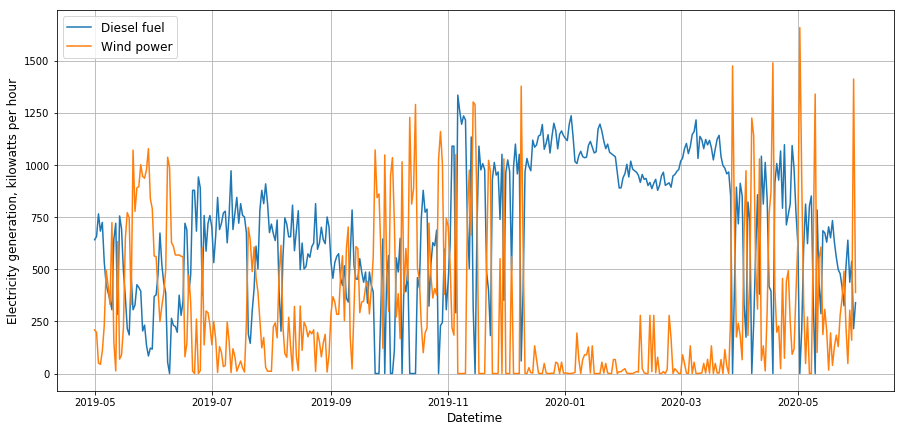

In [23]:
# Make visualisation
plot_diesel_and_wind(df)

Общее количество элементов в рядах: 397.

Определим целевой временной ряд и ряды, которые будут использовать как предикторы

In [31]:
features_to_use = ['wind_power_kWh', 'diesel_time_h', 'wind_time_h',
                   'velocity_max_msec', 'velocity_mean_msec', 'tmp_grad',
                   'diesel_fuel_kWh']
target_series = 'diesel_fuel_kWh'

## Запуск алгоритма для прогноза на 30 элементов, размер обучающей выборки 200, время работы 0.2 минуты

In [ ]:
forecast, obtained_pipeline = run_automl(df=df, features_to_use=features_to_use, 
                                         target_series=target_series, 
                                         forecast_horizon=30,
                                         history_size=200,
                                         timeout=0.2)

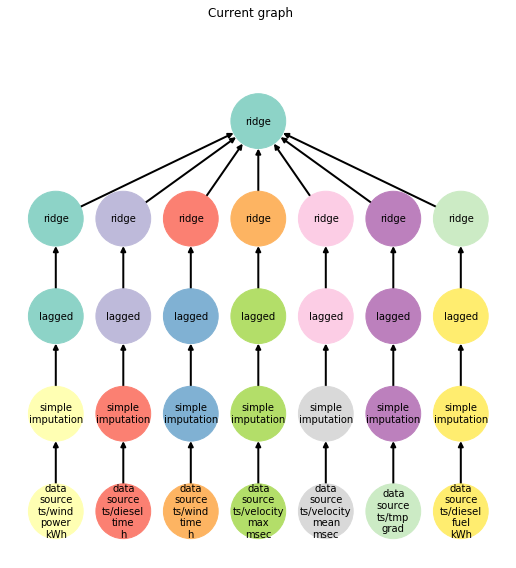

In [36]:
obtained_pipeline.show()

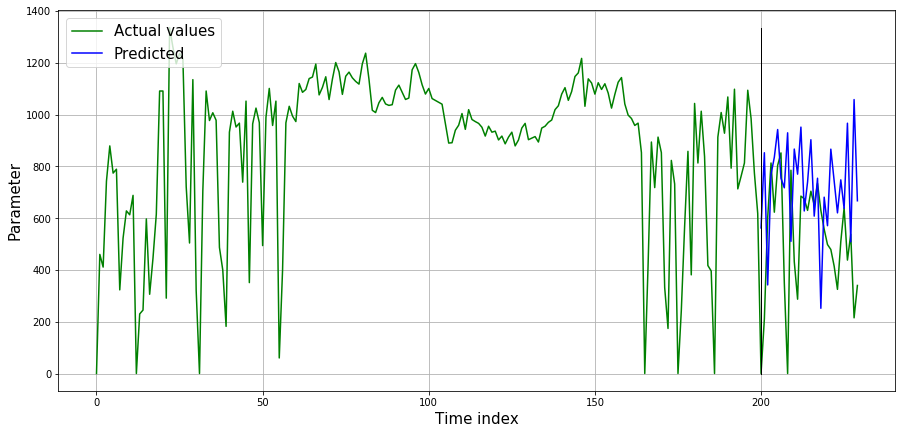

In [38]:
plot_automl_forecast(df, forecast_horizon=30, history_size=200, forecast=forecast)

## Запуск алгоритма для прогноза на 60 элементов, размер обучающей выборки 300, время работы 2 минуты

In [ ]:
forecast_horizon = 60
history_size=300
timeout=2
forecast, obtained_pipeline = run_automl(df=df, features_to_use=features_to_use, 
                                         target_series=target_series, 
                                         forecast_horizon=forecast_horizon,
                                         history_size=history_size,
                                         timeout=timeout)

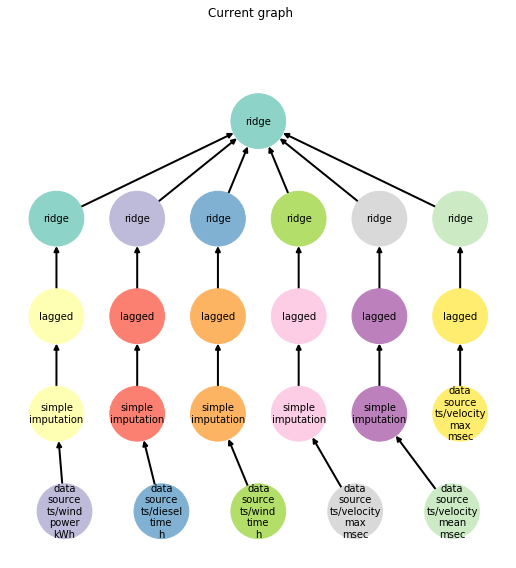

In [41]:
obtained_pipeline.show()

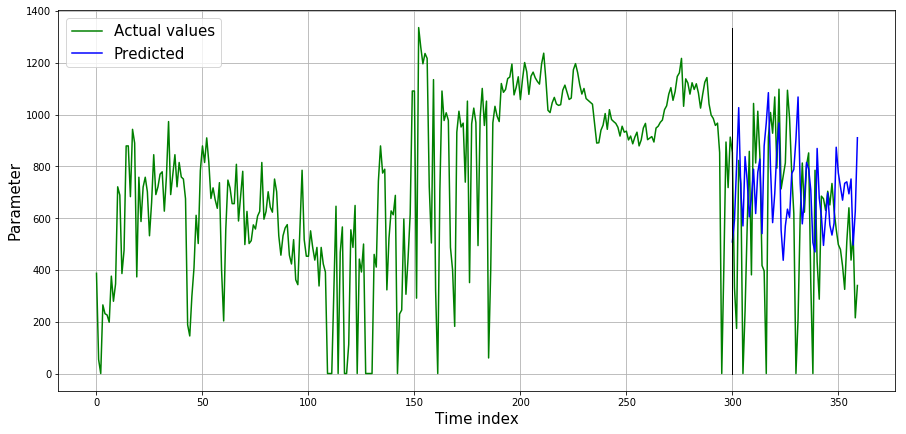

In [42]:
plot_automl_forecast(df, forecast_horizon, history_size, forecast=forecast)